We want to comapre the GTC readout and the model predictions on any given set of images, where there are no available annotations. 

**Remark**: the inference on the images needs to be manually executed, before running this notebook.

In [18]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

In [19]:
def compute_area(predictions_folder, confidence):
    """
    Compute the total organoids area for a given confidence threshold on the predictions.

    Args:
        predictions_folder (str): Path to the folder containing prediction files.
        confidence (float): Confidence threshold for filtering predictions.

    Returns:
        float: The area under the curve (AUC) value.
    """
    predictions_files = [f for f in os.listdir(predictions_folder)]
    df_area = []
    for i, predictions_file in enumerate(predictions_files):
        if predictions_file.endswith(".csv"):
            predictions_path = os.path.join(predictions_folder, predictions_file)
            df = pd.read_csv(predictions_path)
            df = df[df['score'] >= confidence]
            area = df['area'].sum()
            experiment_ID = "_".join(predictions_file.split('_')[:-1])
            well_ID = predictions_file.split('_')[-1].split('.')[0]
            df_area.append([experiment_ID, well_ID, area])
    df_area = pd.DataFrame(df_area, columns=['experiment_ID', 'well_ID', 'area'])
    df_area.sort_values(by=['well_ID'], inplace=True)  
    df_area["area_norm"] = df_area["area"] / df_area["area"].max()
    return df_area

In [20]:
# CTG_file = "../CTG_readout/D192_P1_R2.TXT"
# predictions_folder = "../outupt_D192_P1_R2/D192_7TFP_P1_R2_predictions_confidence_0.0"
# predictions_folder_original = "../outupt_D192_P1_R2_original/D192_7TFP_P1_R2_predictions_confidence_0.0"

CTG_file = "../CTG_readout/D131_P1_SN38_R1.TXT"
predictions_folder = "../outupt_D131_P1_SN38_R1/D131_7TFP_P1_SN38_R1_predictions_confidence_0.0"
predictions_folder_original = "../outupt_D131_P1_SN38_R1_original/D131_7TFP_P1_SN38_R1_predictions_confidence_0.0"

# open the files
ctg = pd.read_csv(CTG_file, sep='\t', header=None)
ctg.columns = ['experiment_ID', 'well_ID', 'CTG']
ctg.sort_values(by=['well_ID'], inplace=True)
ctg['CTG_norm'] = ctg['CTG'] / ctg['CTG'].max()
display(ctg)

,experiment_ID,well_ID,CTG,CTG_norm
0,D131_P1_SN38_R1,A01,98860,0.782839
1,D131_P1_SN38_R1,A02,88446,0.700374
2,D131_P1_SN38_R1,A03,87345,0.691655
3,D131_P1_SN38_R1,A04,93534,0.740664
4,D131_P1_SN38_R1,A05,92827,0.735065
...,...,...,...,...
379,D131_P1_SN38_R1,P20,101170,0.801131
380,D131_P1_SN38_R1,P21,97244,0.770042
381,D131_P1_SN38_R1,P22,103325,0.818195
382,D131_P1_SN38_R1,P23,88722,0.702559


Load the predictions with the fine-tuned model at different level of confidence: 0.0, 0.5, 0.75, 0.9

In [21]:
confidence = [0.0, 0.5, 0.75, 0.9]
predictions = []
for conf in confidence:
    df_area = compute_area(predictions_folder, conf)
    predictions.append(df_area)

In [22]:
confidence = [0.0, 0.5, 0.75, 0.9]
predictions_original = []
for c in confidence:
    df_area = compute_area(predictions_folder_original, c)
    predictions_original.append(df_area)

## Plot the results

Show the correlation between CTG readout at different confidence level 

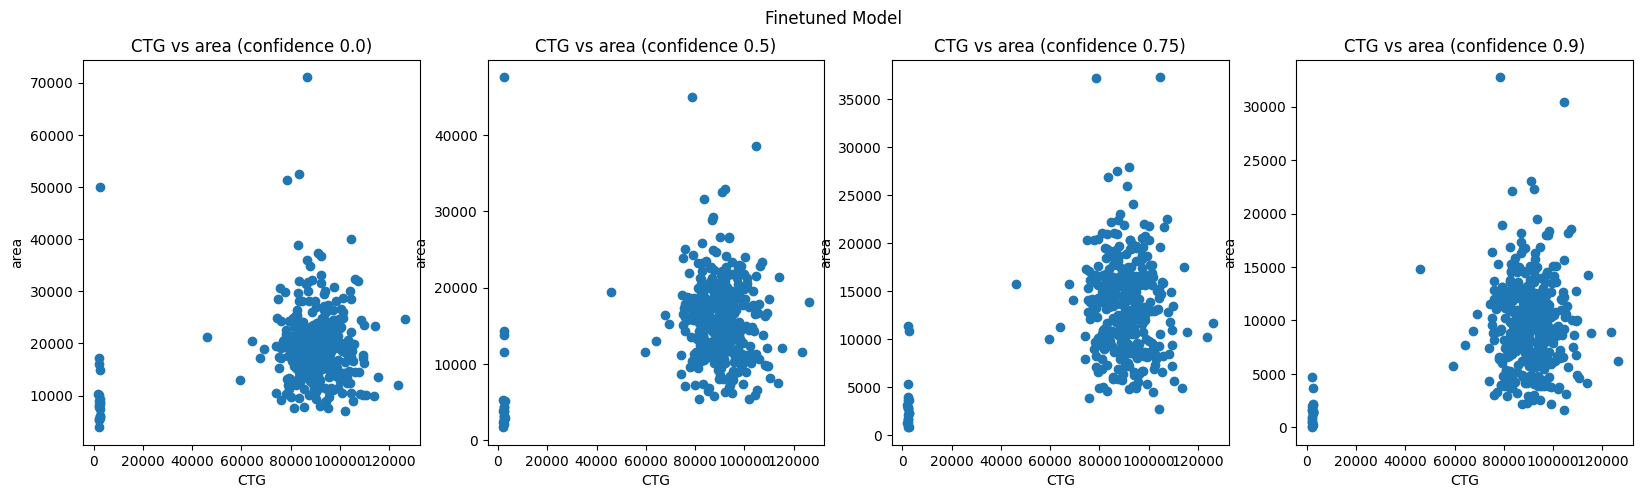

,0.00,0.50,0.75,0.90
pearson,0.197871,0.261819,0.357438,0.361598
spearman,0.057862,0.059767,0.083226,0.136786


In [23]:
i = 0
correaltion = pd.DataFrame(columns=confidence, index=['pearson', 'spearman'])
fig, ax = plt.subplots(1, len(confidence), figsize=(20, 5))
fig.suptitle("Finetuned Model")
for conf, pred in zip(confidence, predictions):
    # display scatterplot to visualize the correlation
    ax[i].scatter(ctg['CTG'], pred['area'])
    ax[i].set_xlabel('CTG')
    ax[i].set_ylabel('area')
    ax[i].set_title(f'CTG vs area (confidence {conf})')
    i+= 1

    # compute correlation
    correaltion.loc["pearson", conf] = pearsonr(ctg['CTG'], pred['area'])[0]
    correaltion.loc['spearman', conf] = spearmanr(ctg['CTG'], pred['area'])[0]

plt.show()
display(correaltion)



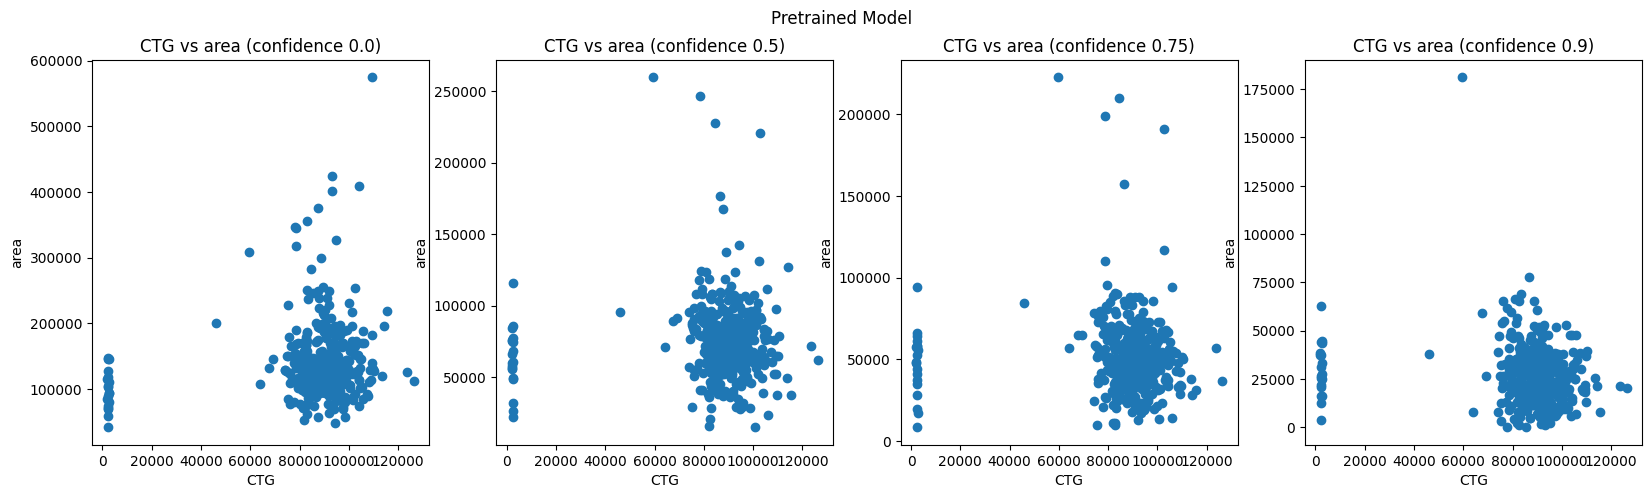

,0.00,0.50,0.75,0.90
pearson,0.14348,0.030979,-0.042847,-0.124646
spearman,0.066944,-0.033118,-0.118844,-0.107087


In [24]:
i = 0
correaltion_pret = pd.DataFrame(columns=confidence, index=['pearson', 'spearman'])
fig, ax = plt.subplots(1, len(confidence), figsize=(20, 5))
fig.suptitle("Pretrained Model")
for conf, pred in zip(confidence, predictions_original):
    # display scatterplot to visualize the correlation
    ax[i].scatter(ctg['CTG'], pred['area'])
    ax[i].set_xlabel('CTG')
    ax[i].set_ylabel('area')
    ax[i].set_title(f'CTG vs area (confidence {conf})')
    i+= 1

    # compute correlation
    correaltion_pret.loc["pearson", conf] = pearsonr(ctg['CTG'], pred['area'])[0]
    correaltion_pret.loc['spearman', conf] = spearmanr(ctg['CTG'], pred['area'])[0]

plt.show()
display(correaltion_pret)

In [25]:
# Compare spearman correlation
print("Correlation indices for Finetuned Model")
display(correaltion)
print("Correlation indices for Pretrained Model")
display(correaltion_pret)

Correlation indices for Finetuned Model


,0.00,0.50,0.75,0.90
pearson,0.197871,0.261819,0.357438,0.361598
spearman,0.057862,0.059767,0.083226,0.136786


Correlation indices for Pretrained Model


,0.00,0.50,0.75,0.90
pearson,0.14348,0.030979,-0.042847,-0.124646
spearman,0.066944,-0.033118,-0.118844,-0.107087
